# 回帰分析：住宅価格の予測

　回帰分析では、離散的なラベルではなく連続値を予測する。例えば、気象データに基づいて明日の天気を予測したり、ソフトウェアプロジェクトの仕様に基づいてプロジェクトの完了にかかる時間を予測したりする。

> **回帰**と**ロジスティック回帰**を混同しないように注意。紛らわしいことに、ロジスティック回帰は回帰アルゴリズムではなく、分類アルゴリズムである。

## Boston Housingデータセット

　今回は、1970年代のボストン近郊の住宅価格の予測を行う。この予測には、犯罪発生率や地方財産税の税率など、当時のボストン近郊に関するデータセット（Boston Housingデータセット）を用いる。

　このデータセットに含まれるデータ数は506個と少なく、404の訓練サンプルと102のテストサンプルに分割されている。また、入力データの**特徴量**（犯罪発生率など）はそれぞれ異なる尺度を使用している。例えば、割合を0～1で表しているものもあれば、1～12の値を取るもの、0～100％で表されるものもある。そのため、訓練データの準備には一工夫が必要になる。

In [1]:
# Boston Housingデータセットの読み込み
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 6us/step


In [2]:
# 特徴量の確認
print(train_data.shape, test_data.shape) # -> 13種類の特徴量がある

(404, 13) (102, 13)


In [3]:
# 住宅価格の確認
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

　住宅価格は1,000ドル単位のため、上記の出力データから考えると、住宅価格は主に10,000～50,000ドルである。中央値を取ると30,000ドルとなる。

## データの準備

　それぞれ全く異なる範囲の値を取る特徴量をニューラルネットワークに供給するためのベストプラクティスは、特徴量ごとの正規化である。入力データの特徴量（入力データ行列の列）ごとに「特徴量の平均値を引き、標準偏差で割る」という処理を行うことで、特徴量の中心が0になり、標準偏差が1になる。

In [4]:
# データの正規化
mean = train_data.mean(axis=0) # 列ごとの平均
x_train = train_data - mean
std = train_data.std(axis=0) # 列ごとの標準偏差
x_train /= std

# テストデータの正規化に使用する値は訓練データのものを使う
x_test = (test_data - mean) / std

## ニューラルネットワークの構築

　利用可能なサンプルの数が少ないため、なるべく小さなネットワークを使うべきである。一般的に、訓練データの数が少ないほど過学習に陥りやすくなるため、小さいネットワークを使うことで過学習を抑制するのが定石である。

　今回は、64ユニットの隠れ層を2つ持つニューラルネットワークを構築する。

In [5]:
from keras import models
from keras import layers

# 同じモデルを複数回インスタンス化する必要があるため、モデル作成関数を準備
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=train_data.shape[1]))
    model.add(layers.Dense(64, activation='relu'))
    # 住宅価格を出力するだけなので、出力層は1ユニットのスカラー回帰層で良い
    model.add(layers.Dense(1)) # スカラー回帰：連続値をひとつだけ予測する回帰
    # 損失関数に平均二乗誤差(mse)を採用：予測値と目的値の誤差を最小化していく
    # 指標に平均絶対誤差(mae)を採用：予測値と目的値の差の絶対値を監視
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## 検証データの準備

　訓練データの数が少なく、単純に分割すると検証データの数が非常に少なくなってしまうような場合、**k分割交差検証**を使用すると良い。k分割交差検証では、利用可能なデータをK個のサンプルセット（フィールド）に分割し、全く同じモデルのインスタンスをK個作成する。その後、各モデルをK-1個のフィールドで訓練し、残り1個のフィールドで評価する。そして、K個の検証スコアの平均を求めることで、検証による評価値を算出する。

例）3分割交差検証  
データを3つのフィールドに分割  
　↓  
フィールド①：|検証| |訓練| |訓練|　→　検証スコア①  
フィールド②：|訓練| |検証| |訓練|　→　検証スコア②  
フィールド③：|訓練| |訓練| |検証|　→　検証スコア③  
　↓  
最終スコア＝検証スコア①～③の平均値

In [6]:
''' k分割交差検証 '''
import numpy as np

k = 4
n_val_samples = len(train_data) // k
n_epochs = 100
all_scores = []

for i in range(k): # GeForce GTX 1070 で～4分程度
    print("processing fold #", i)
    
    # 検証データ準備
    val_data = x_train[i * n_val_samples : (i+1) * n_val_samples]
    val_targets = train_targets[i * n_val_samples : (i+1) * n_val_samples]
    
    # 訓練データ準備：残りのフィールドのデータ
    partial_train_data = np.concatenate([x_train[: i * n_val_samples], x_train[(i+1) * n_val_samples :]], axis=0)
    partial_train_targets = np.concatenate([train_targets[: i * n_val_samples], train_targets[(i+1) * n_val_samples :]], axis=0)
    
    # モデル構築
    model = build_model()
    
    # モデルをサイレントモードで訓練
    model.fit(partial_train_data, partial_train_targets, epochs=n_epochs, batch_size=1, verbose=0)
    
    # モデルを検証データで評価
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [7]:
# 検証スコア確認
all_scores

[2.0956787838794217, 2.220593797098292, 2.859968412040484, 2.40535704039111]

　上記出力データより、検証スコアは2.1～2.9くらいの間で変化していることが分かる。この場合、誤差の平均は2.5程度である。値は1,000ドル単位であるから、2,500ドルの誤差が生じていることになる。

　住宅価格が10,000～50,000ドルであることを考えると、この誤差は非常に大きい。そのため、さらに500エポック訓練することにする。このモデルの性能をエポックごとに記録しておくために、訓練ループの各ステップで検証ログを保存する。

In [9]:
n_epochs = 500
all_mae_histories = []
for i in range(k): # GeForce GTX 1070 で～20分程度
    print("processing fold #", i)
    
    # 検証データ準備
    val_data = x_train[i * n_val_samples : (i+1) * n_val_samples]
    val_targets = train_targets[i * n_val_samples : (i+1) * n_val_samples]
    
    # 訓練データ準備：残りのフィールドのデータ
    partial_train_data = np.concatenate([x_train[: i * n_val_samples], x_train[(i+1) * n_val_samples :]], axis=0)
    partial_train_targets = np.concatenate([train_targets[: i * n_val_samples], train_targets[(i+1) * n_val_samples :]], axis=0)
    
    # モデル構築
    model = build_model()
    
    # モデルをサイレントモードで訓練
    history = model.fit(
        partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=n_epochs, batch_size=1, verbose=0
    )
    
    # 検証ログを保存
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


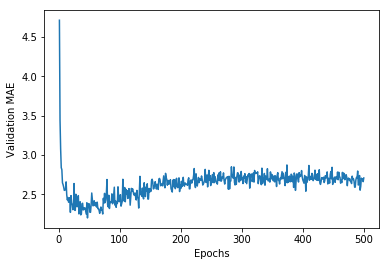

In [11]:
# 検証スコアのプロット
import matplotlib.pyplot as plt
%matplotlib inline

avg_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(n_epochs)]
plt.plot(range(1, len(avg_mae_history) + 1), avg_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

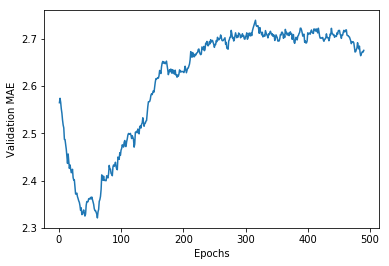

In [15]:
''' 最初の10個のスケーリングが違いすぎるので除外して再度プロット '''
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(avg_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

　上記プロットから、検証スコア（MAE）が80エポック後に大きく改善されていることが分かる。そのポイントを過ぎた後は過学習に陥っている。

　以上の検証から、この問題の訓練には80エポックが最適であることが分かる。

In [17]:
''' 最終的なモデルの訓練 '''
model = build_model()
# データ全体を使って訓練
model.fit(x_train, train_targets, epochs=80, batch_size=16, verbose=0)
# テストデータでの検証スコアを取得
test_mse_score, test_mae_score = model.evaluate(x_test, test_targets)
test_mae_score

102/102 [==============================] - 0s 649us/step


3.1331147212608186

　最終的には、3,133ドルもの誤差が生じている。結局この問題の解決のためには、アルゴリズムを根本的に変えるか、訓練データの数を増やすしかないと思われる。